Research that studies depth of main and attention branches in unet_att_params model

In [19]:
import sys
sys.path.append('../..')

import warnings
warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import datetime
import pprint

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from seismicpro.batchflow import Pipeline, C, V, B, L, I, W

from seismicpro.batchflow.batchflow.models.tf import UNet, VGG7, VGG16, VGG19
from seismicpro.batchflow.batchflow.models.tf.nn.activations import h_sigmoid

from seismicpro.batchflow.batchflow.research import Research, Option, KV, Results
from seismicpro.batchflow.batchflow.utils import plot_results_by_config

from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex, statistics_plot,
                            seismic_plot, spectrum_plot, merge_segy_files)
from seismicpro.models import attention_loss_gauss


from Ground_Roll.src.unet_att2_params import UnetAttParams

%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [2]:
path_raw = '/notebooks/data/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/data/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

,TraceNumber,offset,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,1656,35,1,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,1657,36,2,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,1655,78,3,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,1658,79,4,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,1654,127,5,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...


In [3]:
print("Number of fields:", len(index))

Number of fields: 51


In [4]:
tindex = TraceIndex(index.create_subset(index.indices[:15]))
train_set = SeismicDataset(tindex)
print("Number of traces in train set:", len(tindex))

Number of traces in train set: 51840


In [5]:
def get_filters(num_stages, mode):
    res = [16 * 2**i for i in range(num_stages)]
    return res if mode == 'enc' else res[::-1]

def get_kernels(num_stages, mode):
    res = [7] + [5] * (num_stages - 1)
    return res if mode == 'enc' else res[::-1]

model_config = {
    'initial_block/inputs': 'trace_raw',
    'inputs': dict(trace_raw={'shape': (3000, 1)},
                   lift={'name': 'targets', 'shape': (3000, 1)}),
    'loss': (attention_loss_gauss, {'balance': 0.05}),
    'optimizer': ('Adam', {'learning_rate': 0.0001}),
    'common/data_format': 'channels_last',
    'common/main_base_class': UNet,
    'common/att_base_class': C('att_model'),
    'body': {
        'main': {
            'encoder/num_stages': C('num_stages'),
            'encoder/blocks': dict(layout='ca ca',
                                   filters=L(get_filters)(C('num_stages'), 'enc'),
                                   kernel_size=L(get_kernels)(C('num_stages'), 'enc'),
                                   activation=tf.nn.elu),
            'encoder/downsample': dict(layout='pd',
                                       pool_size=2,
                                       pool_strides=2,
                                       dropout_rate=0.05),
            'embedding': dict(layout='ca ca', kernel_size=5, filters=16 * 2**C('num_stages')),
            'decoder/blocks': dict(layout='ca ca',
                                   filters=L(get_filters)(C('num_stages'), 'dec'),
                                   kernel_size=L(get_kernels)(C('num_stages'), 'dec'),
                                   activation=tf.nn.elu),
            'decoder/upsample': dict(layout='tad',
                                     kernel_size=L(get_kernels)(C('num_stages'), 'dec'),
                                     strides=2,
                                     dropout_rate=0.05,
                                     activation=tf.nn.elu, ),
        },
        'att': {},
    },
    'head': {
        'main': dict(layout='c', filters=1, units=1),
        'att': dict(layout='fa', units=2, activation=h_sigmoid),
    },

    'train_steps': {'step_main': {'scope': 'main_branch'},
                 'step_attention': {'scope': 'attention_branch'}}
}

In [6]:
grid = (Option('att_model', [VGG7, VGG16, VGG19])
        * Option('num_stages', [3, 4, 5, 6]))
list(grid.gen_configs())

[ConfigAlias({'att_model': 'VGG7', 'num_stages': '3'}),
 ConfigAlias({'att_model': 'VGG7', 'num_stages': '4'}),
 ConfigAlias({'att_model': 'VGG7', 'num_stages': '5'}),
 ConfigAlias({'att_model': 'VGG7', 'num_stages': '6'}),
 ConfigAlias({'att_model': 'VGG16', 'num_stages': '3'}),
 ConfigAlias({'att_model': 'VGG16', 'num_stages': '4'}),
 ConfigAlias({'att_model': 'VGG16', 'num_stages': '5'}),
 ConfigAlias({'att_model': 'VGG16', 'num_stages': '6'}),
 ConfigAlias({'att_model': 'VGG19', 'num_stages': '3'}),
 ConfigAlias({'att_model': 'VGG19', 'num_stages': '4'}),
 ConfigAlias({'att_model': 'VGG19', 'num_stages': '5'}),
 ConfigAlias({'att_model': 'VGG19', 'num_stages': '6'})]

In [7]:
def save_model(iteration, experiment, pipeline, model_name, path='./', **kwargs):
    """ Save model to a path."""
    ppl = experiment[pipeline].pipeline

    tz = datetime.timezone(datetime.timedelta(hours=3))
    path = os.path.join(path, str(datetime.datetime.now(tz=tz)).replace(' ', '_'))   
    ppl.save_model_now(model_name, path)
    
    loss = np.array(ppl.get_variable('train_loss'))
    readme = os.path.join(path, 'README.txt')
    with open(readme, 'w') as inpf:
        inpf.write("Iteration: {}\n".format(iteration))
        inpf.write("Final loss: {}\n".format(loss))
        inpf.write("\nConfig:\n")
        inpf.write(pprint.pformat(experiment[pipeline].config.config().config, compact=True))
        inpf.write("\nAdditional Info:\n")
        inpf.write(pprint.pformat(kwargs))
        
    return path

In [8]:
BATCH_SIZE=64
ITERATIONS=1800
TEST_EXECUTE_FREQ=100

In [9]:
def exp_stack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data(batch, **kwagrs):
    return {'trace_raw': exp_stack(batch.raw), 'lift': exp_stack(batch.lift)}

# def make_data_inference(batch, **kwagrs):
#     return {"feed_dict": make_data(batch, **kwagrs)}


train_template = (Pipeline()
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .init_model('dynamic', UnetAttParams, name='unet', config=model_config)
                  .init_variable('train_loss')
                  .train_model('unet', make_data=make_data, fetches='loss_step_main', save_to=V('train_loss'))
                  .run_later(BATCH_SIZE, shuffle=True, n_epochs=None)
                 )

test_template = (Pipeline()
                 .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                 .init_variable('test_loss')
                 .import_model('unet', C('import_from'))
                 .predict_model('unet', make_data=make_data, fetches='loss_step_main', save_to=V('test_loss'))
                 .run_later(BATCH_SIZE, shuffle=True, n_epochs=1))

In [10]:
!rm -r 2_research_res

In [11]:
!rm -r 2_saved_models

rm: cannot remove '2_saved_models': No such file or directory


In [ ]:
res_name = '2_research_res'

research = (Research()
            .add_pipeline(train_template, dataset=train_set, part='train', 
                          variables='train_loss', name='train_ppl')
            .add_pipeline(test_template, dataset=train_set, part='test', 
                          variables='test_loss', name='test_ppl',
                          execute=TEST_EXECUTE_FREQ, run=True, import_from='train_ppl')
#             .add_function(save_model, returns='snapshot_path', name='save_model_fn', logging=True,
#                           execute='last', pipeline='train_ppl', model_name='unet', path='./2_saved_models/noise_dataset_1')
            .add_grid(grid))

research.run(n_iters=ITERATIONS, n_splits=3, name=res_name, bar=True, gpu=[7])

Research 2_research_res is starting...


  0%|          | 0/64800 [00:00<?, ?it/s]

Distributor has 36 jobs with 1800 iterations. Totally: 64800


 10%|█         | 6600/64800 [1:15:04<11:02:04,  1.47it/s]

In [20]:
res = research.load_results(use_alias=True)

In [21]:
res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65448 entries, 0 to 17
Data columns (total 7 columns):
config        65448 non-null object
cv_split      65448 non-null int64
iteration     65448 non-null int64
name          65448 non-null object
repetition    65448 non-null int64
test_loss     648 non-null float64
train_loss    64800 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 4.0+ MB


In [22]:
def plot_results_by_config(results, variables, figsize=None, force_flat=True):
    if isinstance(variables, dict):
        variables = variables.items()
    elif len(variables) == 2 and isinstance(variables[0], str):
        variables = (variables,)

    gbc = results.groupby('config')
    n_configs = len(gbc)
    n_vars = len(variables)

    n_h, n_v = (n_configs, 1) if n_vars == 1 and force_flat else (n_vars, n_configs)

    if figsize is None:
        figsize = (n_h * 5, n_v * 5)

    _, axs = plt.subplots(n_v, n_h, figsize=figsize)
    for x, (config, df) in enumerate(gbc):
        for y, (source, val) in enumerate(variables):
            if n_configs == 1 and n_vars == 1:
                ax = axs
            elif n_configs == 1:
                ax = axs[y]
            elif n_vars == 1:
                ax = axs[x]
            else:
                ax = axs[x, y]
            
            col = 'cv_split' if 'cv_split' in df.columns else 'repetition'

            (df[df['name'] == source]
             .pivot(index='iteration', columns=col, values=val)
             .rename(columns=lambda s: col + str(s))
             .plot(ax=ax))
            ax.set_title(config)
            ax.set_xlabel('Iteration')
            ax.set_ylabel(val.replace('_', ' ').capitalize())
            ax.grid(True)
            ax.legend()

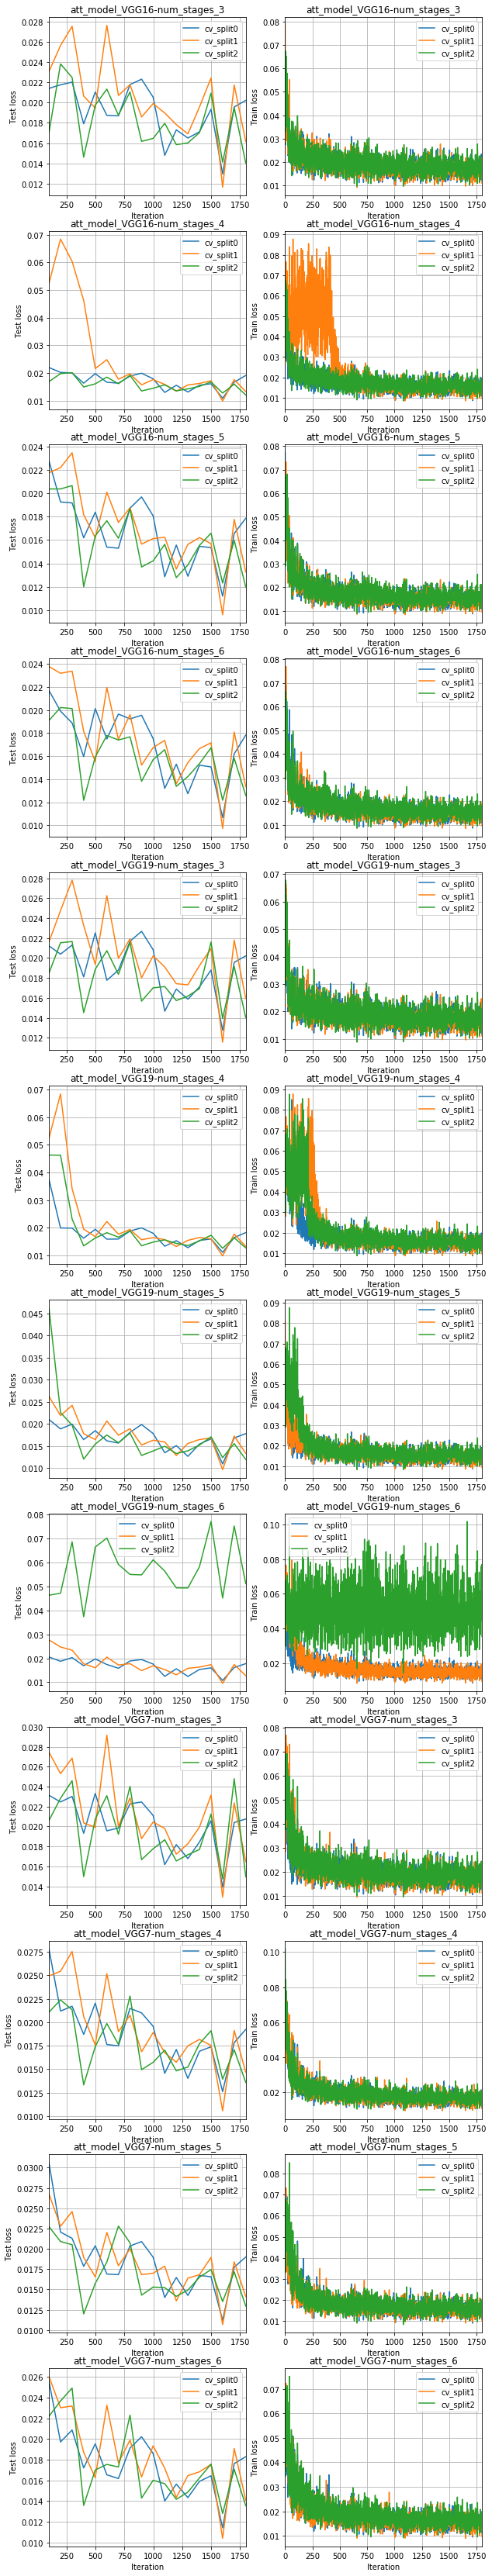

In [23]:
plot_results_by_config(res, {'train_ppl': 'train_loss', 'test_ppl': 'test_loss'})

In [24]:
res2 = research.load_results()
res2.head()

,att_model,cv_split,iteration,name,num_stages,repetition,test_loss,train_loss
0,VGG7,0,0,train_ppl,3,0,NaN,0.063664
1,VGG7,0,1,train_ppl,3,0,NaN,0.042518
2,VGG7,0,2,train_ppl,3,0,NaN,0.047914
3,VGG7,0,3,train_ppl,3,0,NaN,0.052436
4,VGG7,0,4,train_ppl,3,0,NaN,0.043989


In [25]:
(res2[res2.iteration >= 1500]
 .pivot_table(index='att_model', columns='num_stages', values=['train_loss', 'test_loss'], aggfunc=['mean', 'std'])
 .loc[['VGG7', 'VGG16', 'VGG19']]
 .style.background_gradient(axis=None, cmap='cool', subset=['mean'])
 .background_gradient(axis=None, cmap='cool', subset=['std']))

